In [57]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Load Data

In [2]:
O_SA = 18.96 * 1e9 # Ontario Surface Area

In [3]:
niagra_training = np.load('../Data/niagra_training.npy')
niagra_testing = np.load('../Data/niagra_testing.npy')

nbs_training = np.load('../Data/nbs_ontario_training.npy')
nbs_testing = np.load('../Data/calculated_nbs_ontario.npy')

In [4]:
# Net Basin Supply Uncertainty
nbs_uncert = {
    t : (min( [nbs_training[i::12] for i in range(12)][t-1] ),
         max( [nbs_training[i::12] for i in range(12)][t-1] )) for t in range(1, 13)
}

In [5]:
# Niagra Flow Uncertainty
nflow_uncert = {
    t : (min( [niagra_training[i::12] for i in range(12)][t-1] ),
         max( [niagra_training[i::12] for i in range(12)][t-1] )) for t in range(1, 13)
}

In [6]:
# M(t) and m(t)
surface_dict = {
        1 : (73.56, 75.26),
        2 : (73.62, 75.37),
        3 : (73.78, 75.33),
        4 : (73.97, 75.60),
        5 : (74.22, 75.73),
        6 : (74.27, 75.69),
        7 : (74.26, 75.63),
        8 : (74.15, 75.49),
        9 : (74.04, 75.24),
        10 : (73.83, 75.25),
        11 : (73.67, 75.18),
        12 : (73.57, 75.23),
    }

# Construct Simulation and Control Algorithm

In [7]:
def monthly_surface_extremes(month: int):
    if month % 12 != 0: month = month % 12
    else: month = 12
    return surface_dict[month]

In [8]:
def limit_flows(prev_surf, quart_month):
    if quart_month in [i for i in range(1, 13)] + [48]:
        return 11500
    else:
        if prev_surf <= 74.22: return 5950
        elif prev_surf <= 74.34: return 5950 + 1333*(prev_surf-74.22)
        elif prev_surf <= 74.54: return 6111 + 9100*(prev_surf-74.34)
        elif prev_surf <= 74.70: return 7930 + 2625*(prev_surf-74.54)
        elif prev_surf <= 75.13: return 8350 + 1000*(prev_surf-74.70)
        elif prev_surf <= 75.44: return 8780 + 3645*(prev_surf-75.13)
        elif prev_surf <= 75.70: return 9910
        elif prev_surf <= 76: return 10200
        else: return 10700

In [9]:
def g(prev_surf):
    return 555.823*(prev_surf - 0.035 - 69.474)**(1.5)

In [18]:
def update_uncertainty(month_nu, observed_val, uncert_set):
    prev_seen = uncert_set[month_nu]
    if observed_val > prev_seen[1]:
        uncert_set[month_nu] = (prev_seen[0], observed_val)
    elif observed_val < prev_seen[0]:
        uncert_set[month_nu] = (observed_val, prev_seen[1])

In [12]:
def quarter_month_seconds(month_nu: int) -> float:
    '''
    Conversion flow in m^3/s to m^3/(quarter-month)
    '''
    if month_nu in [4, 6, 9, 11]:
        return (1/4)*(2.592 * 1e6)
    elif month_nu == 2:
        return (1/4)*2.4192*1e6
    else:
        return (1/4)*2.6784*1e6

In [70]:
def find_x(month: int, quart_month: int, prev_flow_rate: float, prev_surf: float):
    '''
    cp is cvxpy
    '''
    
    if quart_month % 4 != 0: next_qm_month_surf = surface_dict[month]
    else: 
        if month % 12 != 0: next_qm_month_surf = surface_dict[month + 1]
        else: next_qm_month_surf = surface_dict[1]

    pre_release_rate = g(prev_surf)
    
    min_surf, max_surf = surface_dict[month]
    next_qm_middle = (next_qm_month_surf[0] + next_qm_month_surf[1]) / 2
    
    nflow_i_lb = nflow_uncert[month][0] / (O_SA * 4) # empirical LB on Niagra Flow for quarter month
    nflow_i_ub = nflow_uncert[month][1] / (O_SA * 4) # empirical UB on Niagra Flow for quarter month
    nbs_i_lb = nbs_uncert[month][0] / 4 # empirical LB on Net Basin Supply for quarter month
    nbs_i_ub = nbs_uncert[month][1] / 4 # empirical UB on Net Basin Supply for quarter month

    # Alternative Approach: minimize difference
    x = cp.Variable(1) # Controlled flow rate

    total_flow_rate = x + pre_release_rate
    total_release = ( quarter_month_seconds(month) / O_SA ) * total_flow_rate

    # Might need to build in ability for infeasible to loosen bound
    s_ub = prev_surf + nflow_i_ub + nbs_i_ub - total_release
    s_lb = prev_surf + nflow_i_lb + nbs_i_lb - total_release

    objective = cp.Minimize(cp.maximum(s_ub - next_qm_middle, next_qm_middle - s_lb))

    surface_height = [s_ub <= max_surf, s_lb >= min_surf]
    flow_change = [cp.abs(total_flow_rate- prev_flow_rate) <= 700]
    max_flow = [total_flow_rate  <= limit_flows(prev_surf, quart_month)]
    channel_capacity = [total_flow_rate <= 747*(prev_surf - 69.10)**(1.47)]

    # One more constraint: try to incorporate next month

    constraints = max_flow + channel_capacity  + flow_change + surface_height + [x >= 0]

    prob = cp.Problem(objective, constraints)
    prob.solve()

    return prob, x, total_flow_rate, total_release

In [71]:
def find_relaxed_x(month: int, quart_month: int, prev_flow_rate: float, prev_surf: float):

    pre_release_rate = g(prev_surf)
    
    min_surf, max_surf = surface_dict[month]
    
    nflow_i_lb = nflow_uncert[month][0] / (O_SA * 4) # empirical LB on Niagra Flow for quarter month
    nflow_i_ub = nflow_uncert[month][1] / (O_SA * 4) # empirical UB on Niagra Flow for quarter month
    nbs_i_lb = nbs_uncert[month][0] / 4 # empirical LB on Net Basin Supply for quarter month
    nbs_i_ub = nbs_uncert[month][1] / 4 # empirical UB on Net Basin Supply for quarter month

    # Alternative Approach: minimize difference
    x = cp.Variable(1) # Controlled flow rate

    total_flow_rate = x + pre_release_rate
    total_release = ( quarter_month_seconds(month) / O_SA ) * total_flow_rate

    # Might need to build in ability for infeasible to loosen bound
    s_ub = prev_surf + nflow_i_ub + nbs_i_ub - total_release
    s_lb = prev_surf + nflow_i_lb + nbs_i_lb - total_release

    objective = cp.Minimize(cp.abs(total_flow_rate - prev_flow_rate))

    surface_height = [s_ub <= max_surf, s_lb >= min_surf]
    flow_change = [cp.abs(total_flow_rate- prev_flow_rate) <= 1637]
    max_flow = [total_flow_rate  <= limit_flows(prev_surf, quart_month)]
    channel_capacity = [total_flow_rate <= 747*(prev_surf - 69.10)**(1.47)]

    # One more constraint: try to incorporate next month

    constraints = max_flow + channel_capacity + surface_height + flow_change + [x >= 0]

    prob = cp.Problem(objective, constraints)
    prob.solve()

    return prob, x, total_flow_rate, total_release

In [72]:
solution, x, flow_rate, total_release = find_x(2, 1, 7560.59731424663, 74.62)

/Users/q3/opt/anaconda3/envs/MCM-env/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


In [73]:
solution.status

'optimal'

In [177]:
total_release.value

array([0.2635026])

In [165]:
s_new = 74.8 + niagra_testing[0]/O_SA + nbs_testing[0] - (total_release.value[0]/O_SA)*2.6784*1e6

In [166]:
s_new

75.91401264982608

In [94]:
T = len(nbs_testing)
s0 = 74.62 # Ontario Water Level end of December 2011
f_0 = 7560.59731424663# Flow Rate out of Ontario end of December 2011

nbs_problem_uncertainty = nbs_uncert.copy()
nflow_problem_uncert = nflow_uncert.copy()

month_water_levels = []
qmonth_water_levels = []
month_flows = []
month_average_levels = []
qmonth_flows = []
qmonth_chosen_flows = []

s_t = s0 # End of Month Water Level (m)
f_t = f_0 # End of Month Flow Rate (m^3/s)

for t in range(1, T+1):

    if t % 12 != 0: month = t % 12
    else: month = 12
    seconds = quarter_month_seconds(month)

    month_nbs = nbs_testing[t-1] # m/month
    quart_month_nbs = month_nbs/4 # m/quart_month
    month_niagra_flow = niagra_testing[t-1] # m^3/month
    quart_month_niagra_tot_inflow = month_niagra_flow / (4*O_SA) # m/quart_month

    month_water_levels.append(s_t)
    month_flows.append(f_t)

    s_t_avg = 0

    for qm in range((month - 1)*4 + 1, (month - 1)*4 + 5):
        
        # Given most recent data, make robust decision

        prob, x_rate, flow_rate, qm_release = find_x(month, qm, f_t, s_t)

        if prob.status == 'infeasible':
            print("relaxed x found")
            print("month: ", month)
            prob, x_rate, flow_rate, qm_release = find_relaxed_x(month, qm, f_t, s_t)
            print(abs(flow_rate.value[0] - f_t))

        # Can use prob variable to handle infeasibility

        f_t = flow_rate.value[0]
        qmonth_flows.append(f_t)
        qmonth_chosen_flows.append(x_rate.value[0])  
       
        # Update System
        s_t = s_t + quart_month_niagra_tot_inflow + quart_month_nbs - qm_release.value[0]
        qmonth_water_levels.append(s_t)
        s_t_avg += s_t

        if (qm % 4) ==1:
            update_uncertainty(month, month_nbs, nbs_problem_uncertainty)
            update_uncertainty(month, month_niagra_flow, nflow_problem_uncert)
        
        if (qm % 4 ) == 0:
            average = s_t_avg/4
            month_average_levels.append(average)



/Users/q3/opt/anaconda3/envs/MCM-env/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


relaxed x found
month:  4
1633.7786119353495


In [75]:
# Need to properly subtract flow: with SA
month_flows

[7560.59731424663,
 8378.740752928383,
 6215.056876803222,
 6766.623600724549,
 6617.504079254222,
 6843.959204238482,
 6733.053765669055,
 6506.019130289988,
 6277.462337145951,
 6068.760167736625,
 6732.919219817584,
 6199.089927678302,
 7185.696699910796,
 6237.576662852292,
 6090.6054435447595,
 6805.249000281994,
 6507.446753537386,
 6883.1808154782175,
 6858.735838388667,
 6704.354260939709,
 7301.235090950592,
 7143.599206175717,
 7567.743134187374,
 6712.081474558259,
 8111.3889439006725,
 6711.389050199842,
 5828.880093619534,
 6398.450195800599,
 7352.982558342204,
 7206.633187120592,
 8326.699533371655,
 8161.534887753599,
 8441.986795083656,
 7861.999288909076,
 7640.2112434346045,
 7388.532586042727,
 8212.200153406982,
 6754.7353865589885,
 5718.73522629555,
 6165.087640486257,
 6552.559794586302,
 6905.420611466737,
 8253.33803590249,
 7713.674918882703,
 7779.621949130713,
 8220.895035730584,
 7910.990853537365,
 7379.666244289277,
 8708.17696823812,
 8217.947099880545,

In [76]:
all_depths = np.load('../Data/depth_vectors.npy')

In [77]:
historical_depths = all_depths[0:144, 4]

In [78]:
start_date2 = datetime(2000, 1, 1)
end_date2 = datetime(2012, 1, 1)
date_range2 = [start_date2 + timedelta(days=i * 30) for i in range(len(historical_depths))]

In [79]:
start_date = datetime(2011, 12, 31)
end_date = datetime(2021, 1, 1)
date_range = [start_date + timedelta(days=i * 30) for i in range(len(month_water_levels))]

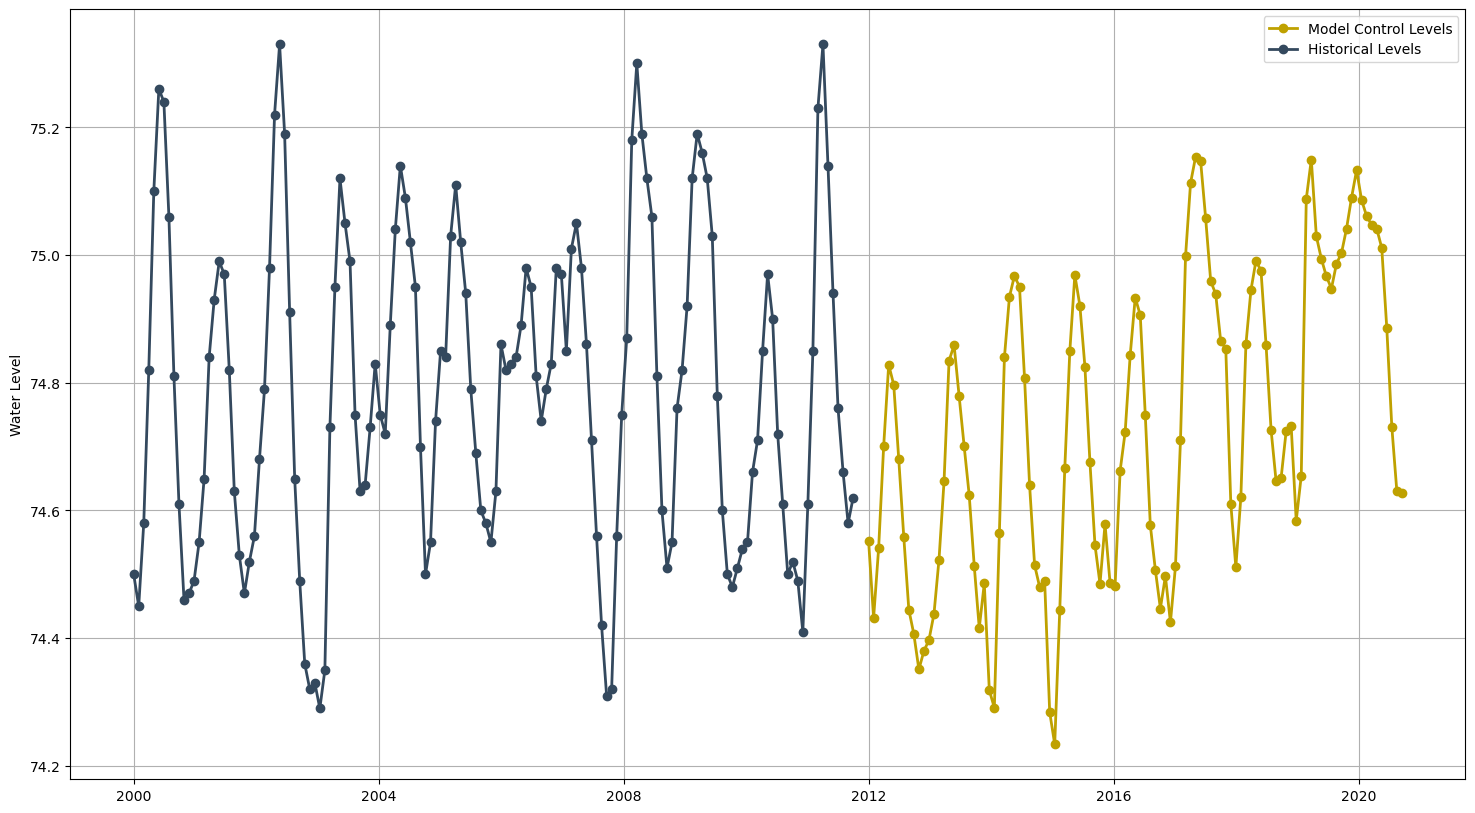

In [98]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(date_range, month_average_levels, linewidth=2, marker='o', linestyle='-', color='#BFA100', label='Model Control Levels')
ax.plot(date_range2, historical_depths, linewidth=2, marker='o', linestyle='-', color='#34495e', label='Historical Levels')

ax.set_ylabel('Water Level')
ax.legend()
ax.grid(True)

plt.savefig(f"../model_vs_historical.png", dpi=400)

# for year in range(start_date.year, end_date.year + 1):
#     ax.axvline(datetime(year, 1, 1), color='red', linestyle='--', linewidth=0.8)

# for year in range(start_date2.year, end_date2.year + 1):
#     ax.axvline(datetime(year, 1, 1), color='red', linestyle='--', linewidth=0.8)

plt.show()

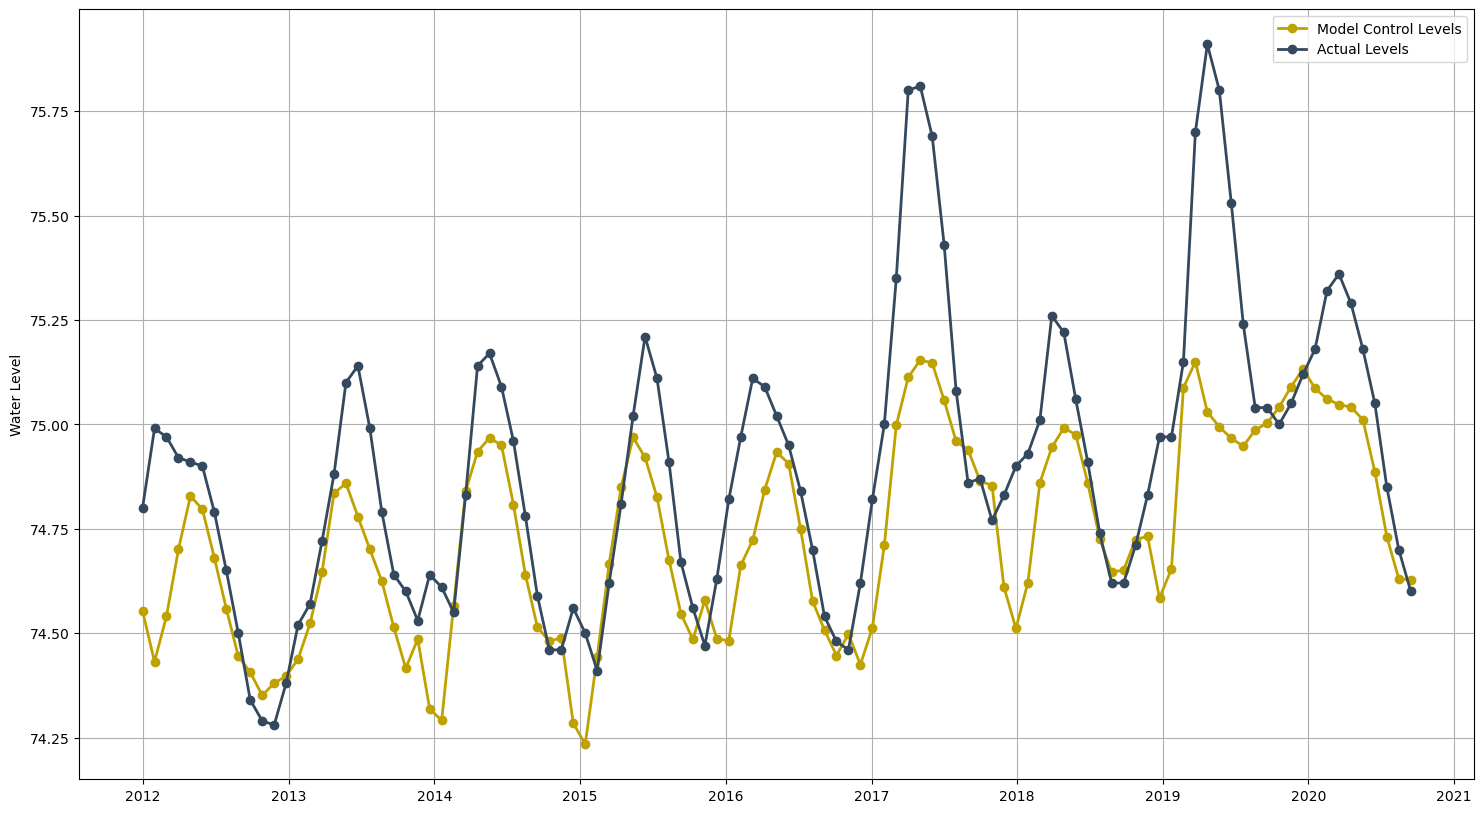

In [97]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(date_range, month_average_levels, linewidth=2, marker='o', linestyle='-', color='#BFA100', label='Model Control Levels')
ax.plot(date_range, all_depths[144:251, 4], linewidth=2, marker='o', linestyle='-', color='#34495e', label='Actual Levels')

ax.set_ylabel('Water Level')
ax.legend()
ax.grid(True)

# for year in range(start_date.year, end_date.year + 1):
#     ax.axvline(datetime(year, 1, 1), color='red', linestyle='--', linewidth=0.8)

# for year in range(start_date2.year, end_date2.year + 1):
#     ax.axvline(datetime(year, 1, 1), color='red', linestyle='--', linewidth=0.8)

plt.savefig(f"../model_vs_actual.png", dpi=400)

plt.show()

In [200]:
month_water_levels

[74.62,
 74.50931879311356,
 74.42947493960747,
 74.6655586714995,
 74.85379226017308,
 74.95918857606587,
 74.90641063839347,
 74.87322697166596,
 74.70199860246389,
 74.50005420557035,
 74.47007674187105,
 74.34185322474987,
 74.38367424654378,
 74.41562011174922,
 74.46859512819223,
 74.53235534598878,
 74.83652447960439,
 75.23128931313708,
 74.99483959203671,
 74.78944945072564,
 74.7763317542659,
 74.57220847760745,
 74.4909630982682,
 74.4007986553506,
 74.50646293644594,
 74.25340212636375,
 74.42506846419505,
 74.89067153991358,
 74.9816726048845,
 74.94679882451801,
 74.94679882389237,
 74.94528281565147,
 74.75001829174998,
 74.57621253131758,
 74.49548700980506,
 74.48397480281504,
 74.47725052507315,
 74.21855623516939,
 74.34971327506096,
 74.88345077937292,
 74.96911987090412,
 74.97279786382866,
 74.96056471121595,
 74.9151251305438,
 74.76390727997148,
 74.58994446421856,
 74.51692749606529,
 74.47374329416358,
 74.61144724310844,
 74.43259682277649,
 74.53518717941581

In [145]:
qmonth_water_levels

[74.57346318599603,
 74.53094669086602,
 74.49208918513563,
 74.45656402253445,
 74.38744583065862,
 74.32363964252406,
 74.26470833271719,
 74.2102546678362,
 74.19856213473541,
 74.1878451706044,
 74.17802145559007,
 74.1690157617782,
 74.231239401435,
 74.29295099388676,
 74.35185111554917,
 74.40488637661822,
 74.43272784865432,
 74.45162163545521,
 74.46444334183687,
 74.47314441146729,
 74.42958324180915,
 74.39957014732101,
 74.37889150513116,
 74.36464418241715,
 74.34291716376728,
 74.32817276887005,
 74.31495940905337,
 74.30236809240463,
 74.2828692822894,
 74.26428841444867,
 74.24658227506485,
 74.22970968469016,
 74.20850479759135,
 74.18774226651973,
 74.16697973544792,
 74.1462172043755,
 74.15159582114788,
 74.15697443792033,
 74.16235305469284,
 74.16773167146543,
 74.1622099504713,
 74.15668822947708,
 74.15116650848282,
 74.14564478748848,
 74.17752284808522,
 74.20940090868233,
 74.24127896927976,
 74.19048909130048]

In [146]:
qmonth_flows

[9203.882084013629,
 9090.045097976952,
 8986.43930494094,
 8892.082635690816,
 8806.096957513508,
 8639.569856100468,
 8486.746289478504,
 8346.375674738552,
 8217.337809134628,
 8189.71417163894,
 8164.4214547152715,
 8141.258847190438,
 5950.0000000612645,
 5964.982121986823,
 6047.24367471233,
 6218.845151332165,
 6701.466027202768,
 6954.8234227518005,
 7126.756882651111,
 7243.434410733,
 7322.614144441426,
 6926.207500578897,
 6653.088340739917,
 6464.912696817429,
 6335.262060167695,
 6137.54619046948,
 6094.194301091731,
 6076.580892393658,
 6059.796667239007,
 6033.804753372987,
 6009.036456564484,
 5985.43417279345,
 5962.943009741703,
 5950.000000056355,
 5950.000000062211,
 5950.000000080209,
 5949.999999944996,
 5949.999999942938,
 5949.999999940908,
 5949.999999938906,
 5949.999999808491,
 5949.999999810311,
 5949.999999812166,
 5949.999999814053,
 5949.9999997278865,
 5949.999999717499,
 5949.999999708267,
 8290.776755106577]